# Add Titles and introductory info here

## Collect Data:

In [1]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [2]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 25)
longs = np.random.uniform(-180, 180, 25)

#print(lats)
#print(longs)

In [3]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)
lat_long

In [4]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

25
25


In [5]:
# Format data for improved legibility
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [6]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Punta Arenas,CL
1,Rikitea,PF
2,Jamestown,SH
3,Margate,ZA
4,Bluff,NZ


In [7]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [8]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Punta Arenas,CL,,,,,,
1,Rikitea,PF,,,,,,
2,Jamestown,SH,,,,,,
3,Margate,ZA,,,,,,
4,Bluff,NZ,,,,,,


In [9]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [10]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Temperature (F)"] = cities_weather["main"]["temp"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
        
    time.sleep(1)
        

0 Punta Arenas
1 Rikitea
2 Jamestown
3 Margate
4 Bluff
5 Saldanha
6 Dawlatabad
7 Vaini
8 Tsihombe
skip
9 Kalaleh
10 Cherskiy
11 Karkaralinsk
skip
12 Hermanus
13 Batagay-Alyta
14 Mullaitivu
skip
15 Ushuaia
16 Kyra
17 Dikson
18 Busselton
19 Padang
20 Ostrovnoy
21 Yellowknife
22 Victoria
23 Biak
24 Port Alfred


In [11]:
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Punta Arenas,CL,-53.15,-70.9167,73.4,21,0,14.97
1,Rikitea,PF,-23.1203,-134.969,77.65,72,97,13.13
2,Jamestown,SH,-15.9387,-5.7168,68.22,85,100,14.03
3,Margate,ZA,-30.8636,30.3705,73.58,85,76,5.35
4,Bluff,NZ,-46.6,168.333,60.01,71,98,4.47
5,Saldanha,ZA,-33.0117,17.9442,62.6,72,0,14.97
6,Dawlatabad,AF,36.4141,64.9053,53.89,49,60,3.74
7,Vaini,TO,-21.2,-175.2,78.8,89,75,13.8
8,Tsihombe,MG,NaN,,,,,
9,Kalaleh,IR,37.3807,55.4916,51.8,93,90,3.53


In [12]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Punta Arenas,CL,-53.15,-70.9167,73.4,21,0,14.97
1,Rikitea,PF,-23.1203,-134.969,77.65,72,97,13.13
2,Jamestown,SH,-15.9387,-5.7168,68.22,85,100,14.03
3,Margate,ZA,-30.8636,30.3705,73.58,85,76,5.35
4,Bluff,NZ,-46.6,168.333,60.01,71,98,4.47
5,Saldanha,ZA,-33.0117,17.9442,62.6,72,0,14.97
6,Dawlatabad,AF,36.4141,64.9053,53.89,49,60,3.74
7,Vaini,TO,-21.2,-175.2,78.8,89,75,13.8
8,Kalaleh,IR,37.3807,55.4916,51.8,93,90,3.53
9,Cherskiy,RU,68.75,161.3,-3.53,68,5,1.5


In [13]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

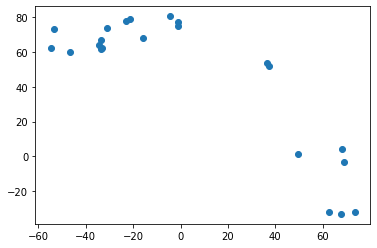

In [14]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Temperature (F)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()



# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

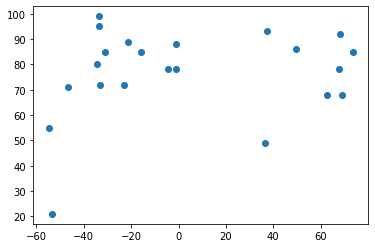

In [15]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

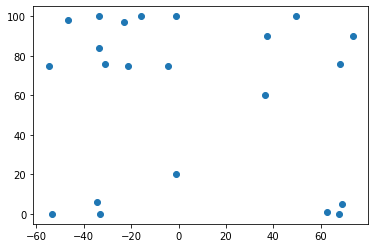

In [16]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

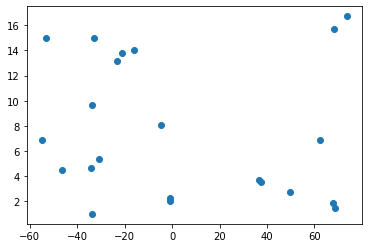

In [17]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

In [21]:
# The second requirement is to run linear regression on each relationship. This time, separate the plots 
# into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 
# degrees latitude):

# Create bins and bin data

bins = [-90, 0, 90]
labels = ["south", "north"]

weather_df["Hemisphere"] = pd.cut(weather_df["Latitude"], bins=bins, labels=labels)
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Hemisphere
0,Punta Arenas,CL,-53.15,-70.9167,73.4,21,0,14.97,south
1,Rikitea,PF,-23.1203,-134.969,77.65,72,97,13.13,south
2,Jamestown,SH,-15.9387,-5.7168,68.22,85,100,14.03,south
3,Margate,ZA,-30.8636,30.3705,73.58,85,76,5.35,south
4,Bluff,NZ,-46.6,168.333,60.01,71,98,4.47,south
5,Saldanha,ZA,-33.0117,17.9442,62.6,72,0,14.97,south
6,Dawlatabad,AF,36.4141,64.9053,53.89,49,60,3.74,north
7,Vaini,TO,-21.2,-175.2,78.8,89,75,13.8,south
8,Kalaleh,IR,37.3807,55.4916,51.8,93,90,3.53,north
9,Cherskiy,RU,68.75,161.3,-3.53,68,5,1.5,north


In [24]:
# Split data into two frames, one for each hemisphere

weather_north_df = weather_df.loc[weather_df["Hemisphere"] == "north"]
weather_north_df.reset_index(inplace=True, drop=True)
weather_north_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Hemisphere
0,Dawlatabad,AF,36.4141,64.9053,53.89,49,60,3.74,north
1,Kalaleh,IR,37.3807,55.4916,51.8,93,90,3.53,north
2,Cherskiy,RU,68.75,161.3,-3.53,68,5,1.5,north
3,Batagay-Alyta,RU,67.8006,130.411,-33.12,78,0,1.86,north
4,Kyra,RU,49.5776,111.975,1.13,86,100,2.75,north
5,Dikson,RU,73.5069,80.5464,-32.1,85,90,16.71,north
6,Ostrovnoy,RU,68.0531,39.5131,4.21,92,76,15.73,north
7,Yellowknife,CA,62.456,-114.353,-31.88,68,1,6.91,north


In [25]:
# Same for southern hemisphere

weather_south_df = weather_df.loc[weather_df["Hemisphere"] == "south"]
weather_south_df.reset_index(inplace=True, drop=True)
weather_south_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Hemisphere
0,Punta Arenas,CL,-53.15,-70.9167,73.4,21,0,14.97,south
1,Rikitea,PF,-23.1203,-134.969,77.65,72,97,13.13,south
2,Jamestown,SH,-15.9387,-5.7168,68.22,85,100,14.03,south
3,Margate,ZA,-30.8636,30.3705,73.58,85,76,5.35,south
4,Bluff,NZ,-46.6,168.333,60.01,71,98,4.47,south
5,Saldanha,ZA,-33.0117,17.9442,62.6,72,0,14.97,south
6,Vaini,TO,-21.2,-175.2,78.8,89,75,13.8,south
7,Hermanus,ZA,-34.4187,19.2345,64,80,6,4.65,south
8,Ushuaia,AR,-54.8,-68.3,62.6,55,75,6.91,south
9,Busselton,AU,-33.65,115.333,61.61,99,84,1.01,south


In [ ]:
# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

In [18]:
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

# After each pair of plots, take the time to explain what the linear regression is modeling. 
# For example, describe any relationships you notice and any other analysis you may have.